In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
# 一些超参数
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
sequence_len=64
# 如果有GPU，该脚本将使用GPU进行计算
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

In [4]:
class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

tok = char_tokenizer(datasets['whole_func_string'])
len(tok.char2ind)

98

In [5]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        '''
        循环神经网络的神经元（支持批量计算）
        参数
        ----
        input_size ：int，输入数据的特征长度
        hidden_size ：int，隐藏状态的特征长度
        '''
        super().__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden=None):
        '''
        向前传播
        参数
        ----
        x ：torch.FloatTensor
            输入数据的集合，形状为(B, T, C)，其中B表示批量大小，T表示文本长度，C表示文字特征的长度（input_size）
        hidden ：torch.FloatTensor
            初始的隐藏状态，形状为(B, H)，其中H表示隐藏状态的长度（hidden_size）
        返回
        ----
        hidden ：torch.FloatTensor，所有隐藏状态的集合，形状为(B, T, H)
        '''
        re = []
        B, T, C = x.shape
        x = x.transpose(0, 1)  # (T, B, C)
        if hidden is None:
            hidden = self.init_hidden(B, x.device)
        for i in range(T):
            # x[i]的形状是(B, C); hidden的形状是(B, H)
            combined = torch.cat((x[i], hidden), dim=1)  # (B, C + H)
            hidden = F.relu(self.i2h(combined))  # (   B, H)
            re.append(hidden)
        result_tensor = torch.stack(re, dim=0)   # (T, B, H)
        return result_tensor.transpose(0, 1)     # (B, T, H)

    def init_hidden(self, B, device):
        # 默认的初始隐藏状态全部等于0
        return torch.zeros((B, self.hidden_size), device=device)

class CharRNNBatch(nn.Module):

    def __init__(self, vs):
        '''
        双层的循环神经网络（支持批量计算）
        参数
        ----
        vs ：int，字典大小
        '''
        super().__init__()
        # 定义文字嵌入的特征长度
        self.emb_size = 256
        # 定义隐藏状态的特征长度
        self.hidden_size = 128
        # 文字嵌入层
        self.embedding = nn.Embedding(vs, self.emb_size)
        # 随机失活
        self.dp = nn.Dropout(0.4)
        # 第一层循环神经网络
        self.rnn1 = RNN(self.emb_size, self.hidden_size)
        # 第二层循环神经网络
        self.rnn2 = RNN(self.hidden_size, self.hidden_size)
        # 语言建模头，根据隐藏状态预测下一个字母是什么
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        '''
        向前传播
        参数
        ----
        x ：torch.LongTensor，当前字母在字典中的位置，形状为(B, T)
        返回
        ----
        output ：torch.FloatTensor，预测结果的logits，形状为(B, T, vs)
        '''
        emb = self.embedding(x)      # (B, T,  C)
        h = self.dp(self.rnn1(emb))  # (B, T,  H)
        # 第一层的隐藏状态是第二层的输入
        h = self.dp(self.rnn2(h))    # (B, T,  H)
        # 使用第二层的隐藏状态预测下一个字母是什么
        output = self.h2o(h)         # (B, T, vs)
        return output

model = CharRNNBatch(len(tok.char2ind)).to(device)

In [6]:
# 展示模型结构
model

CharRNNBatch(
  (embedding): Embedding(98, 256)
  (dp): Dropout(p=0.4, inplace=False)
  (rnn1): RNN(
    (i2h): Linear(in_features=384, out_features=128, bias=True)
  )
  (rnn2): RNN(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
  )
  (h2o): Linear(in_features=128, out_features=98, bias=True)
)

In [7]:
@torch.no_grad()
def generate_batch(model, idx, max_new_tokens=300):
    '''
    利用模型生成文本（反复使用模型进行预测）
    参数
    ----
    model ：CharRNNBatch，生成文本的模型
    idx ：torch.LongTensor，当前字母在字典中的位置，形状为(1, T)
    max_new_tokens ：int，生成文本的最大长度
    返回
    ----
    out ：list[int]，生成的文本
    '''
    # 将模型切换至评估模式
    model.eval()
    for _ in range(max_new_tokens):
        # 限制背景长度，使之与模型训练时的状况更相符
        # 当然也可以不限制
        context = idx[:, -sequence_len:]
        # 在文本生成时，模型的计算效率很低，因为有很多重复计算
        logits = model(context)
        # 只使用最后一个预测结果
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        # 根据模型预测的概率，得到最终的预测结果（下一个字母）
        # 这一步运算有一定随机性
        ix = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, ix), dim=1)
        if ix.item() == 0:
            break
    # 将模型切换至训练模式
    model.train()
    return idx.tolist()[0]

In [8]:
# 使用模型来生成文本
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def*ZO(F/of("YP{BZE G|uw=3:1'_$?Q9NN[{KQ=CK(AM:iKcaR;+Q3j<sAegWS$ö0Nx!qyT3"yMm5Za)'W~5\Wm&B"({r
cdtMh^DA11zc<|e|>


In [9]:
def process(data, sequence_len=sequence_len):
    '''
    根据文本生成训练数据
    '''
    # text是字符串列表
    text = data['whole_func_string']
    inputs, labels = [], []
    for i in text:
        enc = tok.encode(i)
        # 0对应着文本结束
        enc += [0]
        # 将文本转换为多个训练数据
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            # 预测标签是下一个字母，因此只需要挪动一个位置即可
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
# 将文本转换为训练数据，里面包含inputs和labels
tokenized = tokenized.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([605913, 64]), torch.Size([605913, 64]))

In [10]:
# 构建数据读取器
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(test_loader))

{'inputs': tensor([[16, 76, 85,  ..., 69, 67, 80],
         [ 2,  2,  2,  ..., 71, 72, 71],
         [89, 37, 81,  ..., 70, 40, 75],
         ...,
         [76, 71, 69,  ...,  2,  2,  2],
         [ 2, 19,  1,  ..., 74, 67, 86],
         [48, 81, 84,  ..., 78,  2, 70]], device='cuda:0'),
 'labels': tensor([[76, 85, 81,  ..., 67, 80,  2],
         [ 2,  2,  2,  ..., 72, 71, 84],
         [37, 81, 79,  ..., 40, 75, 71],
         ...,
         [71, 69, 86,  ...,  2,  2,  2],
         [19,  1,  2,  ..., 67, 86,  2],
         [81, 84, 79,  ...,  2, 70, 75]], device='cuda:0')}

In [11]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    # 随机使用多个批量数据来预估模型效果
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        # 根据cross_entropy的定义，需要对logits进行转置运算
        # 具体细节请参考cross_entropy的官方文档
        logits = logits.transpose(-2, -1)
        loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 4.572356224060059, 'test': 4.573554515838623}

In [12]:
def train_rnn(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            # 根据cross_entropy的定义，需要对logits进行转置运算
            # 具体细节请参考cross_entropy的官方文档
            logits = logits.transpose(-2, -1)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

In [13]:
l = train_rnn(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.4990, test loss 1.6117
epoch  1: train loss 1.3739, test loss 1.4928
epoch  2: train loss 1.3112, test loss 1.4462
epoch  3: train loss 1.2822, test loss 1.4168
epoch  4: train loss 1.2611, test loss 1.3976
epoch  5: train loss 1.2440, test loss 1.3893
epoch  6: train loss 1.2383, test loss 1.3751
epoch  7: train loss 1.2313, test loss 1.3710
epoch  8: train loss 1.2095, test loss 1.3622
epoch  9: train loss 1.2253, test loss 1.3593


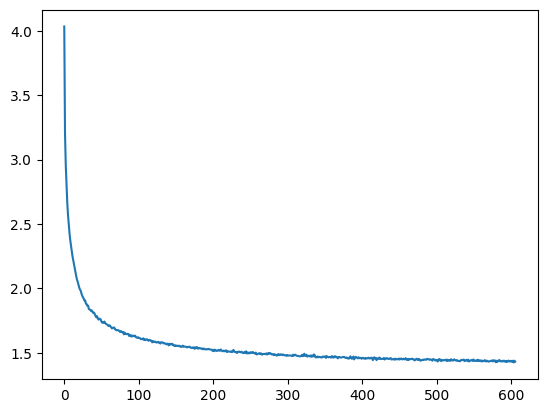

In [14]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [15]:
# 使用模型来生成文本
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def name=2.9], False,
                "fiend num rawfo data a verifien the resunc to end
                # Deraming or not 'las1: semrine DataFrame.

        >>> c.ichurrert.gat.ines = MLsib, inmente`,
               whineQuiter is not None in data.

    2.e dlec('dingentrine())
    __bosle' matrix lic
